# CS5228 Rental Prediction

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from matplotlib.colors import ListedColormap
# load data
train_data = pd.read_csv('./data/processed/train.csv')
test_data = pd.read_csv('./data/processed/test.csv')

X_train, y_train = train_data.drop(columns='monthly_rent'), train_data['monthly_rent'].copy()
X_test = test_data

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Plotting the data

In [5]:
def plot_validation_results(param_to_scores):

    plt.figure()

    param_to_validation_scores = {k: scores[1] for (k, scores) in param_to_scores.items()}
    
    # Plot the scores for each fold
    for param, scores in param_to_validation_scores.items():
        plt.scatter([param] * len(scores), scores)

    # Calculate mean and standard variation across all folds for each parameter value
    score_mean = np.array([np.mean(v) for k,v in sorted(param_to_validation_scores.items())])
    score_std = np.array([np.std(v) for k,v in sorted(param_to_validation_scores.items())])
    
    # Plot error bar
    plt.errorbar(sorted(param_to_validation_scores.keys()), score_mean, yerr=score_std)
    
    plt.xlabel('param')
    plt.ylabel('Cross-Validation RSME Score')
    plt.show()

    

def plot_scores(param_to_scores):

    plt.figure()

    param_to_training_scores = {k: scores[0] for (k, scores) in param_to_scores.items()}
    param_to_validation_scores = {k: scores[1] for (k, scores) in param_to_scores.items()}
    
    # Calculate mean and standard variation across all folds for each parameter value
    training_score_mean = np.array([np.mean(v) for k,v in sorted(param_to_training_scores.items())])
    validation_score_mean = np.array([np.mean(v) for k,v in sorted(param_to_validation_scores.items())])
    
    # Plot error bar
    plt.plot(sorted(param_to_training_scores.keys()), training_score_mean, label ='Training Score')
    plt.plot(sorted(param_to_validation_scores.keys()), validation_score_mean, label ='Validation Score')
    plt.legend(loc='lower right') 
    
    plt.xlabel('param')
    plt.ylabel('Cross-Validation RSME Score')
    plt.show()  
    
# plot_learning_curve
def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

   
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Score')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')

    plt.xlabel('Number of Training Samples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

## Best Parameters for Gradient Boosting Regressor

In [10]:
name_GradientBoosting = 'Gradient Boosting'
params = {
    'n_estimators': 800, 
    'learning_rate': 0.03, 
    'min_samples_split': 5,
    'max_depth': 5, 
    'max_features': 'sqrt', 
    'subsample': 0.8, 
    'random_state': 42,
    'verbose': 1}

model_GradientBoosting = GradientBoostingRegressor(** params)
print(f'Training {name_GradientBoosting}...')

model_GradientBoosting.fit(X_train, y_train)
y_pred = model_GradientBoosting.predict(X_test)

y_train_pred = model_GradientBoosting.predict(X_train)

print(f'{name_GradientBoosting} training completed.')
result_df = pd.DataFrame({
        'Id': range(len(y_pred)),
        'Predicted': y_pred
    })
save_path = './data/predictions/' + name_GradientBoosting + '.csv'
result_df.to_csv(save_path, index=False)
print(f'{name_GradientBoosting} training result saved.\n')

print('{} evaluation:\n'.format(name_GradientBoosting))

mse_GradientBoosting = mean_squared_error(y_train, y_train_pred)
mae_GradientBoosting = mean_absolute_error(y_train, y_train_pred)
print(mse_GradientBoosting,mae_GradientBoosting)

# Calculate the RMSE based on another prediction
# pred_best = pd.read_csv('./data/predictions/Gradient Boosting.csv')
# y_pred_best = pred_best['Predicted']
# mse_GradientBoosting = mean_squared_error(y_pred, y_pred_best)
# rmse_GradientBoosting = np.sqrt(mse_GradientBoosting)
# print(rmse_GradientBoosting)

Training Gradient Boosting...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1      474821.8238        9437.3511           37.52s
         2      463463.8449        6534.7084           32.33s
         3      453840.1183       16635.1520           31.09s
         4      450801.1208       12898.3871           29.86s
         5      440533.6005        1810.9768           29.23s
         6      434695.4038       12955.1785           29.36s
         7      429152.5699       23374.5837           28.96s
         8      420574.7898       -4503.4342           28.87s
         9      414316.1492       14887.3000           28.68s
        10      404231.1871       -3763.4719           28.54s
        20      350670.6141        1558.9893           28.22s
        30      315882.4872        1946.1878           27.36s
        40      289137.8145       -4967.7613           27.37s
        50      272400.0427       -3125.1644           26.87s
        60      259930.6668         659

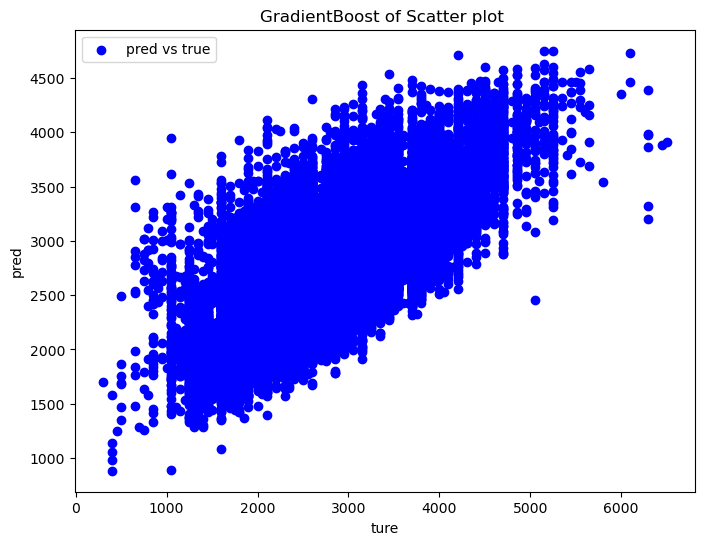

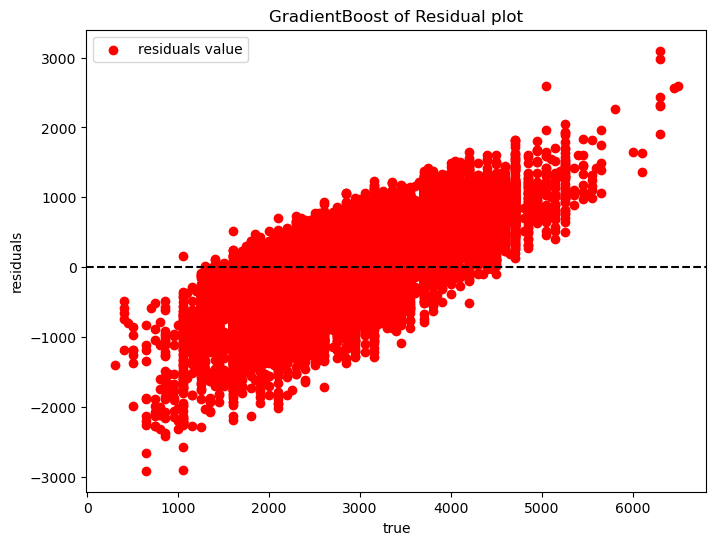

In [5]:
#Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='pred vs true')
plt.xlabel('ture')
plt.ylabel('pred')
plt.legend()
plt.title('GradientBoost of Scatter plot ')
plt.show()

# Residual plot
residuals = y_train - y_train_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_train, residuals, color='red', label='residuals value')
plt.xlabel('true')
plt.ylabel('residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title('GradientBoost of Residual plot')
plt.show()

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      464730.7481       11821.2366           29.10s
         2      456315.2650       29061.1179           16.83s
         3      449977.3159       36420.4032           12.40s
         4      445172.0865       19702.8214           10.19s
         5      433810.9213       -2713.3902            8.75s
         6      405297.7837      -77057.9742            7.87s
         7      423884.1110      125966.0375            7.14s
         8      404614.9023      -34863.6972            6.65s
         9      398493.9087        5649.1900            6.32s
        10      395657.1272       14681.5105            5.99s
        20      333252.7248       34557.1586            5.29s
        30      290432.2154       -9540.3801            4.83s
        40      263109.1028       -9349.8442            4.54s
        50      246825.7238        5295.5796            4.23s
        60      228327.1634        1221.2569            4.02s
       

         8      416396.5460         264.8388           16.77s
         9      412774.0364       14463.9150           16.53s
        10      402588.1553        1942.4749           16.31s
        20      353546.6960        -663.0565           15.69s
        30      314273.5099       -3691.7618           15.13s
        40      288671.8457       15744.3779           14.66s
        50      271304.0532       -7678.2944           14.34s
        60      259559.4691        8512.1177           14.04s
        70      247423.7062       -5400.4431           13.71s
        80      241662.3944      -12741.1510           13.42s
        90      236449.5383        1818.2166           13.09s
       100      235952.0000        3730.6032           12.78s
       200      221436.7037        5203.3913            9.88s
       300      213623.2751        1694.2342            7.26s
       400      209012.7792       -3681.9940            4.80s
       500      205186.4715        -627.3558            2.46s
       6

        80      207670.1645      -11633.4227            3.01s
        90      200623.5620       -6801.5649            2.94s
       100      201919.0432       21280.6173            2.88s
       200      168880.7251       -6715.6032            2.29s
       300      152451.2155      -16414.3028            1.69s
       400      141334.3535        1016.5041            1.12s
       500      129972.2260       -7053.8019            0.55s
       600      117684.8475       -9753.6855            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1      472152.9123       13154.5314            6.13s
         2      464638.6498       24154.8158            6.45s
         3      457928.7237       29386.2854            6.33s
         4      446228.8294       -6686.5464            6.31s
         5      428125.6562      -20370.7831            6.30s
         6      425659.5822       41026.8753            6.28s
         7      416405.5648        8431.1935            6.37s
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      480883.3785        5974.8987           24.42s
         2      474778.4961        7514.0091           25.65s
         3      467914.8903       12195.8925           24.90s
         4      457025.6324        6133.5052           24.07s
         5      451398.0255        8360.0897           23.30s
         6      445296.0377       22788.9281           23.31s
         7      431120.0218       -7127.4194           23.37s
         8      429765.0136       14028.3487           23.16s
         9      422854.7046       11681.8524           23.18s
        10      413543.8498        6787.7460           23.54s
        20      361310.8199       14694.5677           22.97s
        30      318508.4151        -156.4154           23.66s
        40      293662.7702        8973.3475           22.60s
        50      276348.0088       -1541.0181           21.54s
        60      262123.2807       -4414.4315           20.84s
       

        20      343321.5375        9997.6492            6.67s
        30      302745.8016       15991.6400            6.48s
        40      272668.3371      -15621.1990            6.40s
        50      258728.8132        7480.5510            6.32s
        60      246813.5969       -3297.3052            6.16s
        70      235324.5627       -8392.9457            6.04s
        80      231178.7208        9473.1080            5.91s
        90      223185.1321       -9823.0234            5.79s
       100      221969.4074       17127.2478            5.67s
       200      202388.7430       15626.4723            4.45s
       300      187420.8521       -1483.0546            3.22s
       400      178567.4720       -4696.9577            2.09s
       500      167723.1647      -13841.9529            1.03s
       600      165570.8323         533.6124            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1      472083.6593        8277.3575           10.16s
       

       100      235996.8514       10535.7299           13.78s
       200      217630.9440         850.1531           10.74s
       300      213983.4374        7957.7688            7.88s
       400      209498.7103       -3936.4572            5.16s
       500      205757.5027        5214.0343            2.56s
       600      202498.5812        1865.8366            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1      478014.5585        8038.0035           17.82s
         2      468680.4645        2865.2142           17.41s
         3      460420.3446       18109.5528           17.80s
         4      449497.3852        6277.8841           17.64s
         5      439791.6695        2817.1108           17.34s
         6      433169.3471        6831.0616           17.09s
         7      426748.1805       13864.2238           17.11s
         8      422247.8389        7281.6276           16.90s
         9      416064.6430        1896.9492           16.73s
       

        20      346858.5379        4589.8247            8.02s
        30      303450.7727      -16712.2846            8.04s
        40      283228.5085       16130.1296            7.82s
        50      264629.7431        5839.0765            7.62s
        60      251007.9441        4022.7994            7.40s
        70      239070.4814       -2828.8420            7.25s
        80      233785.5047        1370.7117            7.14s
        90      229191.0382        9460.7904            7.01s
       100      226794.6387       11147.6735            6.88s
       200      205984.9234        3664.9499            5.44s
       300      199612.1319       20087.1942            4.01s
       400      192018.8946        1089.1625            2.64s
       500      183061.6968      -12597.4204            1.31s
       600      181535.8949        2949.8791            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1      475740.3753        9177.8366           10.68s
       

       100      235045.8939      -12827.3360           18.94s
       200      222828.0783       -3253.6019           14.71s
       300      219122.1691       10609.9429           10.73s
       400      214215.0983        4549.7712            6.97s
       500      210209.0495       -7238.2113            3.41s
       600      208500.7960       12381.7382            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1      479662.1037        7458.4345           19.92s
         2      468400.5524       14441.9928           20.68s
         3      457385.1362        7702.3435           20.93s
         4      449476.8758       20057.7960           20.45s
         5      440091.8825        8949.0299           20.04s
         6      433011.2325       17679.0975           20.41s
         7      422663.4394        3571.5017           20.51s
         8      417535.6399        4859.8425           19.87s
         9      410915.1004        1687.5495           19.70s
       

        20      336749.8621        -906.1305            9.69s
        30      306238.8446        9915.0901            9.56s
        40      282621.2482        1489.9004            9.42s
        50      267930.6573        8396.5780            9.25s
        60      251458.4901         503.1340            9.07s
        70      243571.6738        6997.7842            8.87s
        80      236506.2228       -1661.9018            8.69s
        90      235148.9813       23302.7984            8.50s
       100      230261.5626       10263.2343            8.28s
       200      214377.5999        8757.6840            6.61s
       300      205399.9403       -2774.0600            4.92s
       400      198842.3151        8666.0951            3.27s
       500      193629.0602       -4820.1695            1.63s
       600      190566.9063        8999.7838            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1      477010.6832        8480.7548           12.81s
       

       100      236276.0044        -254.4261           16.22s
       200      223211.4736       -3231.2203           12.81s
       300      218599.1817        9457.9688            9.44s
       400      214203.4886        7104.0969            6.28s
       500      210417.3749       -3735.8461            3.14s
       600      208455.6339        -839.9699            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1      476729.9734        7387.0250           22.48s
         2      468699.5278       25903.3299           21.25s
         3      458871.6567       10383.5517           20.74s
         4      449200.0149       -2929.7988           21.02s
         5      436349.4930       -3425.0976           20.99s
         6      429493.8986       17080.7245           20.83s
         7      426098.2541       26740.6918           20.98s
         8      414721.9503       -2900.9542           21.06s
         9      409552.1914       18658.5022           21.00s
       

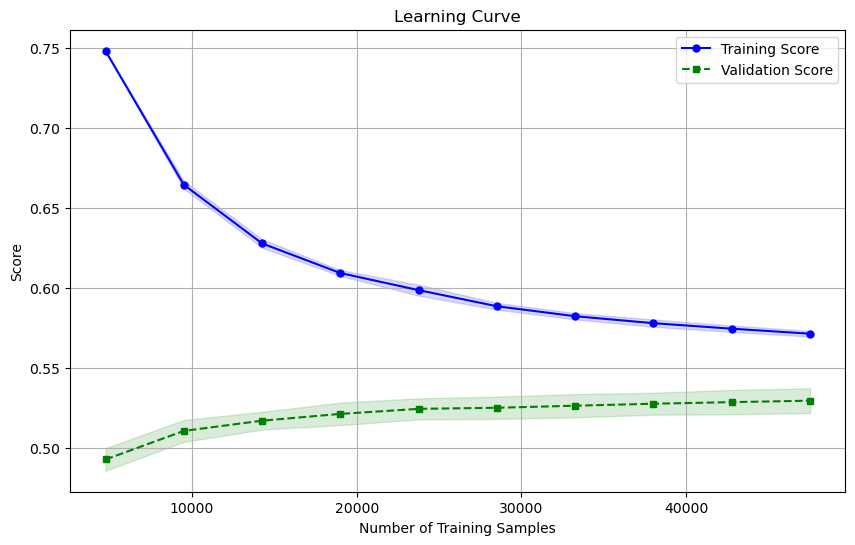

In [4]:
plot_learning_curve(model_GradientBoosting, X_train, y_train)

## Grid Search for Gradient Boosting Regressor

In [ ]:

# Only considered hyperparameter: max depth of trees
param_grid = {
    'n_estimators': [400, 500, 600],
    'learning_rate': [0.01,0.02,0.03,0.04],
    'max_depth': [4,5,6],
    'subsample': [0.8],
    'min_samples_split': [5],
    "max_features": ["sqrt"],
    "verbose" : [1],
}

model_GradientBoosting = GradientBoostingRegressor(random_state=42)

# for param in param_choices:
#     regressor = GradientBoostingRegressor(** params1,max_depth=param)
#     scores = cross_validate(regressor, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', return_train_score= True)
#     rsme_train = scores['train_score'] * (-1)
#     rsme_valid = scores['test_score'] * (-1)
#     param_to_scores[param] = (rsme_train, rsme_valid)
#     print('param = {}, RSME training = {:.1f} ({:.1f}), RSME validation = {:.1f} ({:.1f})'
#           .format(param, np.mean(rsme_train), np.std(rsme_train), np.mean(rsme_valid), np.std(rsme_valid)))

grid_search = GridSearchCV(model_GradientBoosting, param_grid, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

# best_params_: {'learning_rate': 0.03, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 600, 'subsample': 0.8, 'verbose': 1}
# best_score_: -478.4959703927231

## Best Parameters for XGBoost Regressor

In [14]:
name_XGB = 'XGBRegressor'
params = {
    "n_estimators": 1200,
    "learning_rate": 0.03,
    "max_depth": 4,
    "grow_policy": "depthwise",
    "subsample": 0.8,
    "random_state" : 42
}

model_XGB = XGBRegressor(** params)
print(f'Training {name_XGB}...')

model_XGB.fit(X_train, y_train)
y_pred = model_XGB.predict(X_test)

y_train_pred = model_XGB.predict(X_train)

print(f'{name_XGB} training completed.')
result_df = pd.DataFrame({
        'Id': range(len(y_pred)),
        'Predicted': y_pred
    })
save_path = './data/predictions/' + name_XGB + '.csv'
result_df.to_csv(save_path, index=False)
print(f'{name_XGB} training result saved.\n')

print('{} evaluation:\n'.format(name_XGB))

mse_GradientBoosting = mean_squared_error(y_train, y_train_pred)
mae_GradientBoosting = mean_absolute_error(y_train, y_train_pred)
print(mse_GradientBoosting,mae_GradientBoosting)


Training XGBRegressor...
XGBRegressor training completed.
XGBRegressor training result saved.

XGBRegressor evaluation:

208411.28518871212 346.89454708728726


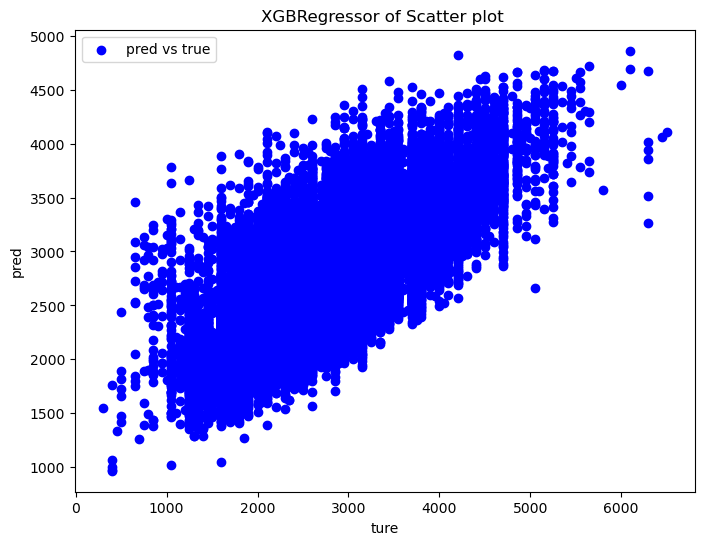

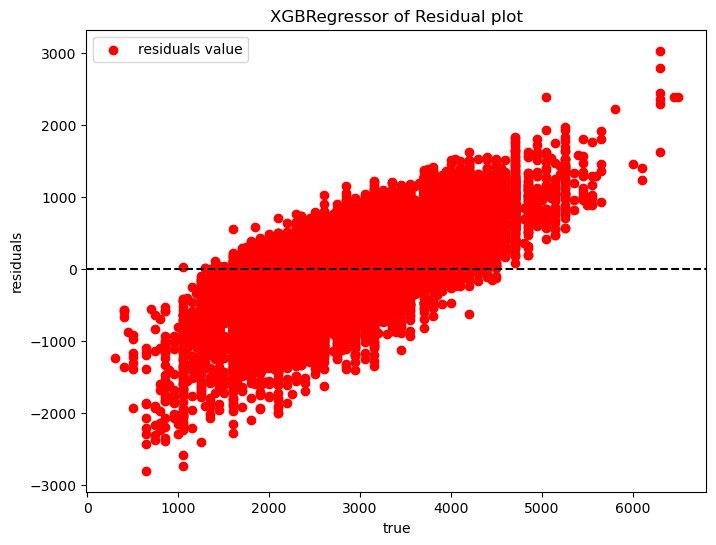

In [6]:
#Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='pred vs true')
plt.xlabel('ture')
plt.ylabel('pred')
plt.legend()
plt.title('XGBRegressor of Scatter plot ')
plt.show()

# Residual plot
residuals = y_train - y_train_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_train, residuals, color='red', label='residuals value')
plt.xlabel('true')
plt.ylabel('residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title('XGBRegressor of Residual plot')
plt.show()

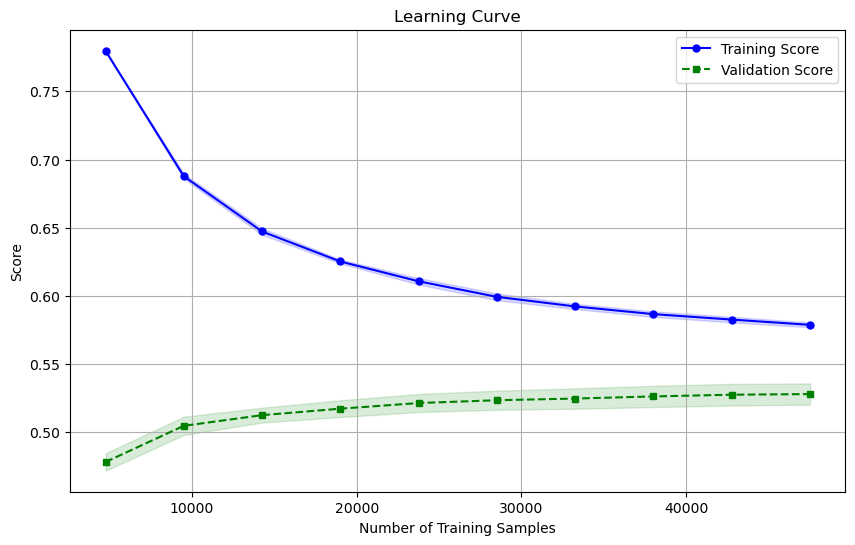

In [7]:
plot_learning_curve(model_XGB, X_train, y_train)

## Grid Search for XGBoost Regressor

In [ ]:

# Only considered hyperparameter: max depth of trees
param_grid = {
    'n_estimators': [900, 1000, 1100],
    'learning_rate': [0.01,0.02,0.03, 0.04,0.05],
    'max_depth': [3, 4, 5],
    'grow_policy': ['depthwise', 'lossguide'],
    'subsample': [0.8],
}

model_XGBRegressor = XGBRegressor(random_state=42)

# for param in param_choices:
#     regressor = GradientBoostingRegressor(** params1,max_depth=param)
#     scores = cross_validate(regressor, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', return_train_score= True)
#     rsme_train = scores['train_score'] * (-1)
#     rsme_valid = scores['test_score'] * (-1)
#     param_to_scores[param] = (rsme_train, rsme_valid)
#     print('param = {}, RSME training = {:.1f} ({:.1f}), RSME validation = {:.1f} ({:.1f})'
#           .format(param, np.mean(rsme_train), np.std(rsme_train), np.mean(rsme_valid), np.std(rsme_valid)))

grid_search = GridSearchCV(model_XGBRegressor, param_grid, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

# best_params_: {'grow_policy': 'depthwise', 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.8}
# best_score_: -479.1326945958325

## Combine the two models

PS: This is the best model we have found so far.

In [8]:
# Combined model
name_combined = 'Combined'

# Combine the predictions of the two models: Gradient Boosting and XGBRegressor
# read the predictions
pred_GradientBoosting = pd.read_csv('./data/predictions/Gradient Boosting.csv')
pred_XGB = pd.read_csv('./data/predictions/XGBRegressor.csv')
y_pred_GradientBoosting = pred_GradientBoosting['Predicted']
y_pred_XGB = pred_XGB['Predicted']

# Combine the predictions
y_pred_combined = 0.5 * y_pred_GradientBoosting + 0.5 * y_pred_XGB

# Save the combined predictions
result_df = pd.DataFrame({
        'Id': range(len(y_pred_combined)),
        'Predicted': y_pred_combined
    })
save_path = './data/predictions/' + name_combined + '.csv'
result_df.to_csv(save_path, index=False)
print(f'{name_combined} training result saved.\n')

Combined training result saved.



In [15]:
# Combined model
name_combined = 'Combined_1'

# Combine the predictions of the two models: Gradient Boosting and XGBRegressor
# read the predictions
pred_SVM = pd.read_csv('./data/predictions/SVM.csv')
pred_GradientBoosting = pd.read_csv('./data/predictions/Gradient Boosting.csv')
pred_XGB = pd.read_csv('./data/predictions/XGBRegressor.csv')
y_pred_GradientBoosting = pred_GradientBoosting['Predicted']
y_pred_XGB = pred_XGB['Predicted']
y_pred_SVM = pred_SVM['Predicted']

# Combine the predictions
y_pred_combined = 0.45 * y_pred_GradientBoosting + 0.4 * y_pred_XGB + 0.15 * y_pred_SVM

# Save the combined predictions
result_df = pd.DataFrame({
        'Id': range(len(y_pred_combined)),
        'Predicted': y_pred_combined
    })
save_path = './data/predictions/' + name_combined + '.csv'
result_df.to_csv(save_path, index=False)
print(f'{name_combined} training result saved.\n')

Combined_1 training result saved.

